<a href="https://colab.research.google.com/github/thatisdrtruman/other-uni-coursework/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import nltk
import sklearn
import matplotlib.pyplot as plt
from collections import Counter

#to make the code os agonstic
import os

#all necessary nltk features
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


from google.colab import drive



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string
'''
All these gives the articles, categories, and frequency of words.
'''
# Required NLTK download for vader
nltk.download('vader_lexicon')
# And for stopwords
nltk.download('stopwords')
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# returning the number of texts in the article
def length_of_article(article):
  return len(article)

# mandatory feature 1: returns a dictionary of words in the article and their frequency (relative frequency)
def word_frequency(textlist):
    words = textlist
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    return word_counts

# feature 2: returns an adjective describing the article's average emotion
def article_sentient(article):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = sentiment_analyzer.polarity_scores(article)
    compound_score = sentiment_scores['compound']
    #Accepted convention definition of what constitiutes positive, negative or neutral article
    if sentiment_scores['compound'] >= 0.05:
        return 'positive', compound_score
    if sentiment_scores['compound'] <= -0.05:
        return 'negative', compound_score
    return 'neutral', compound_score

#feature 3: check if the article has the corresponding category keywords:
def has_keyword(text, category):
    keywords = {
            "politics": ["politics", "election", "parliament", "government", "minister"],
            "entertainment": ["film", "movie", "actor", "celebrity", "music", "television"],
            "sport": ["football", "tennis", "cricket", "athlete", "game", "sports"],
            "tech": ["technology", "computer", "software", "internet", "mobile", "digital"],
            "business": ["economy", "market", "company", "finance", "stock", "industry"]
        }

    for keyword in keywords[category]:  # Iterate through the list of keywords
        if keyword in text:  # Check if the keyword is in the text
            return 1  # Keyword found!
    return 0  # No keywords found

#gives the tokenised article, the number of words and the dictionary of the frequency of words
def preprocess_text(text, category):
    # 'text' is the entire article without lemmatizing
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Lemmatize the tokens, removing all stopwords
    blocking_stop_words = set(stopwords.words('english'))

    lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalnum() and token.lower() not in blocking_stop_words]

    '''
    Uncomment below lemmatized_tokens if you want to include the stopwords in the results.
    Just comment out the avove lemmatized_tokens
    '''
    #lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalnum() and token.lower()]

    # Gives the article in its tokenized form
    this_article = " ".join(lemmatized_tokens)
    # Runs word_frequency function
    frequency_words = word_frequency(lemmatized_tokens)
    # Runs average article emotion
    average_emotion, emotion_score = article_sentient(text)
    # Runs if the article has a keyword in the designated categories, see feature 3
    has_keywords = has_keyword(text, category)
    # return to main programme with the three results
    return this_article, length_of_article(lemmatized_tokens), frequency_words, average_emotion, emotion_score, has_keywords


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# puts all of the text, category, number of text in text file, corpus and frequency of words in article, average emotion, and if the article has keywords
def output(data):
  df = pd.DataFrame(data, columns=['text', 'category', 'number of text', 'frequency of words', 'article emotion', 'compound score', 'has keyword'])
  return df

In [4]:
# Selecting the top k features to use the chi-squared test
from sklearn.feature_selection import chi2, SelectKBest

def select_features(X_train, y_train, k=1000):  # k is the number of features to select
    selector = SelectKBest(chi2, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)
    return X_train_new, selector.get_support(indices=True)  # Return selected features and their indices

In [5]:
#Train and evaluate the model with Naive Bayes and determine their performance

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse as sp

def train_and_evaluate_model(X, y):
    """Trains a Naive Bayes model and evaluates its performance."""
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.25, random_state=42)  # Split data

    model = MultinomialNB()  # Create model instance
    model.fit(X_train, y_train)  # Train the model

    y_pred = model.predict(X_test)  # Make predictions

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    return accuracy, precision, recall, f1  # Return evaluation metrics

Your data:
Your dataset has: category
business         444
entertainment    328
politics         377
sport            345
tech             352
Name: has keyword, dtype: int64 .
Which in percentage of all articles in the same category: category
business         0.870588
entertainment    0.849741
politics         0.904077
sport            0.675147
tech             0.877805
dtype: float64 .
On average, the number of words per article is: category
business         192.264706
entertainment    189.989637
politics         250.690647
sport            178.246575
tech             279.326683
Name: number of text, dtype: float64. 
                                                   text  category  \
0     eu fraud clampdown urged eu member state faili...  politics   
1     really divide party gap labour tory nowadays o...  politics   
2     lib dems unveil election slogan liberal democr...  politics   
3     tory unveil quango blitz plan plan abolish 162...  politics   
4     kennedy criticises tax

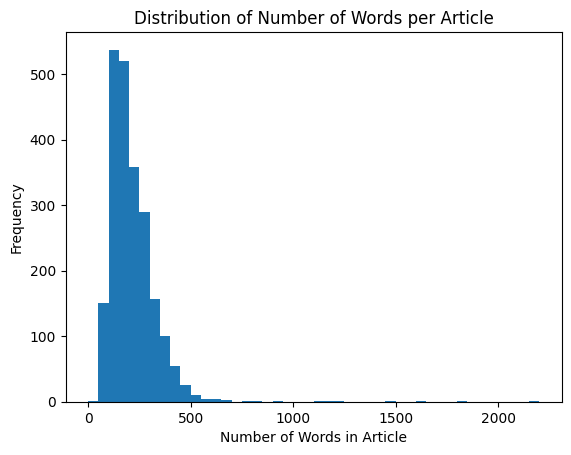

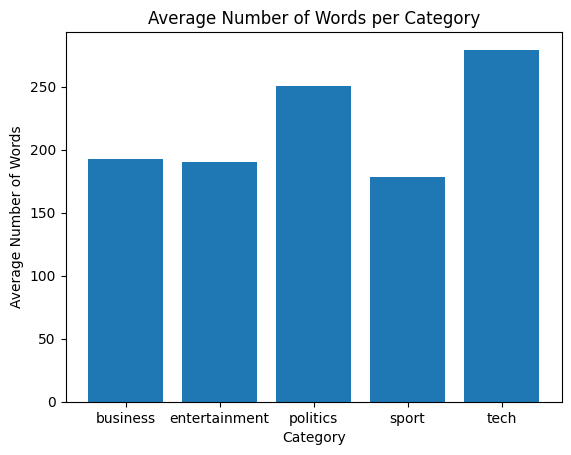

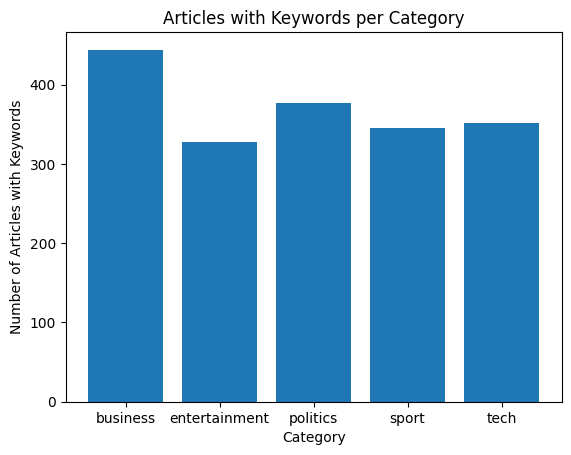

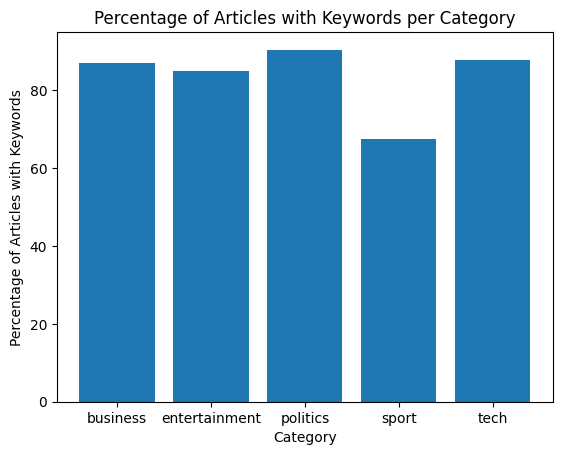

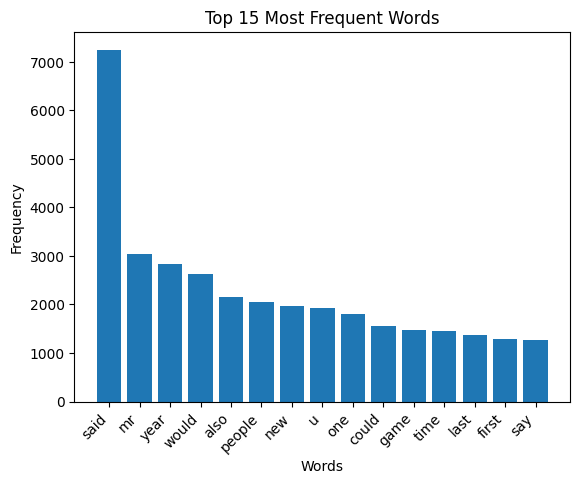

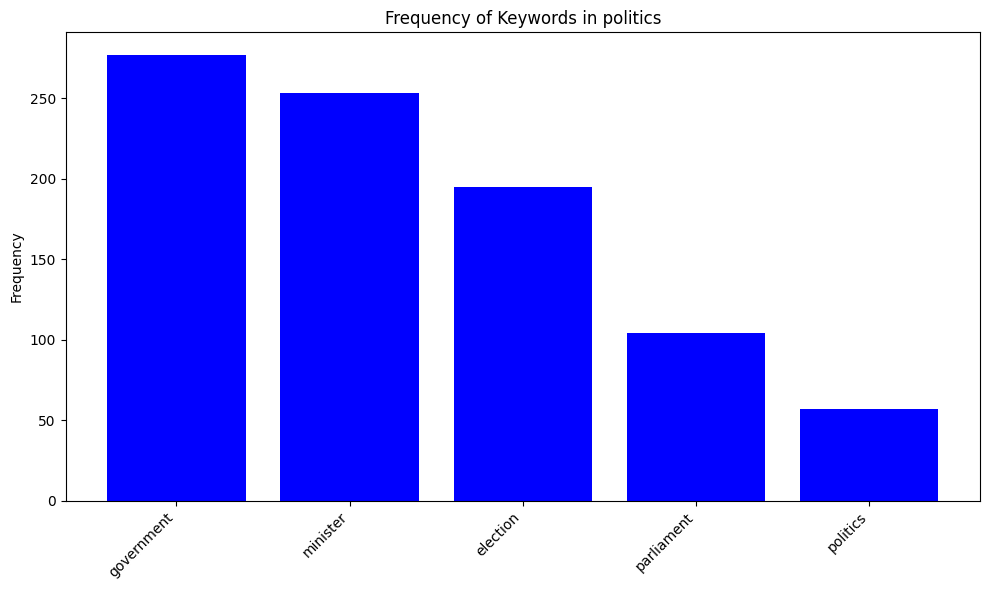

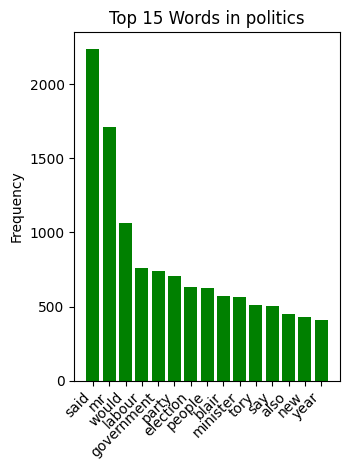

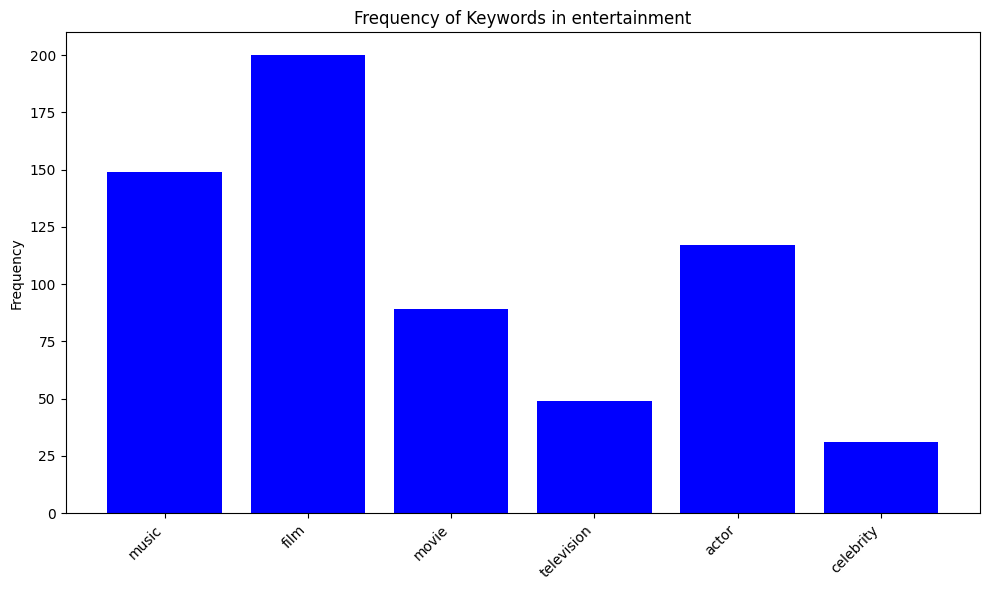

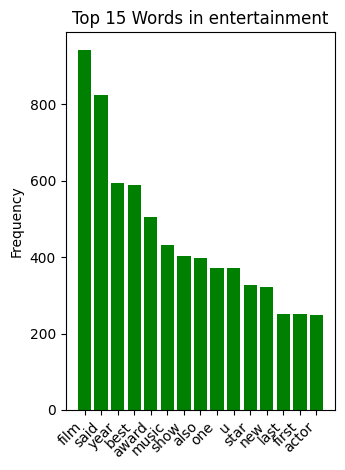

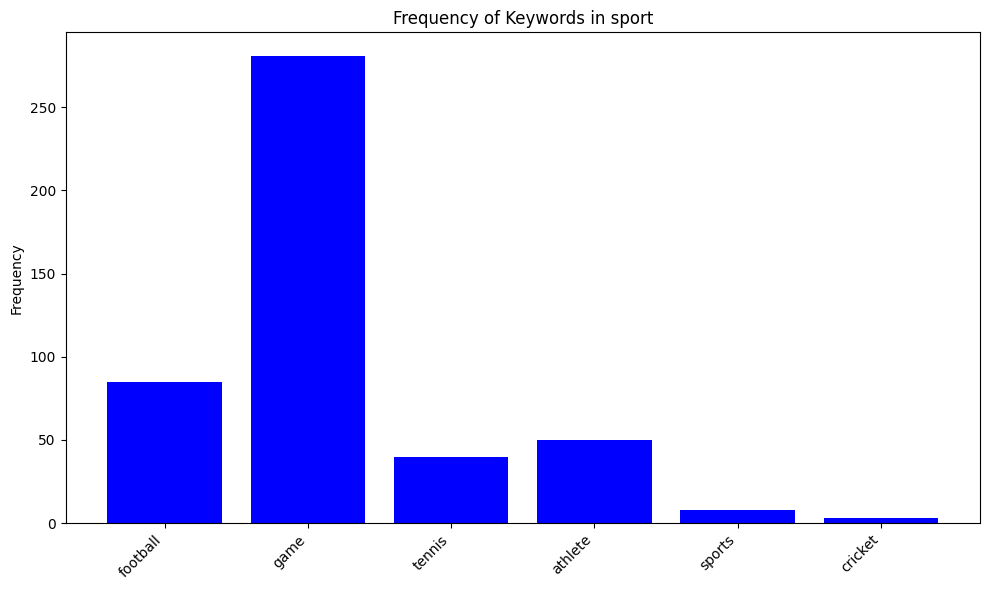

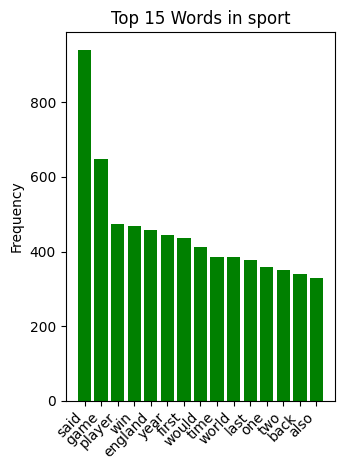

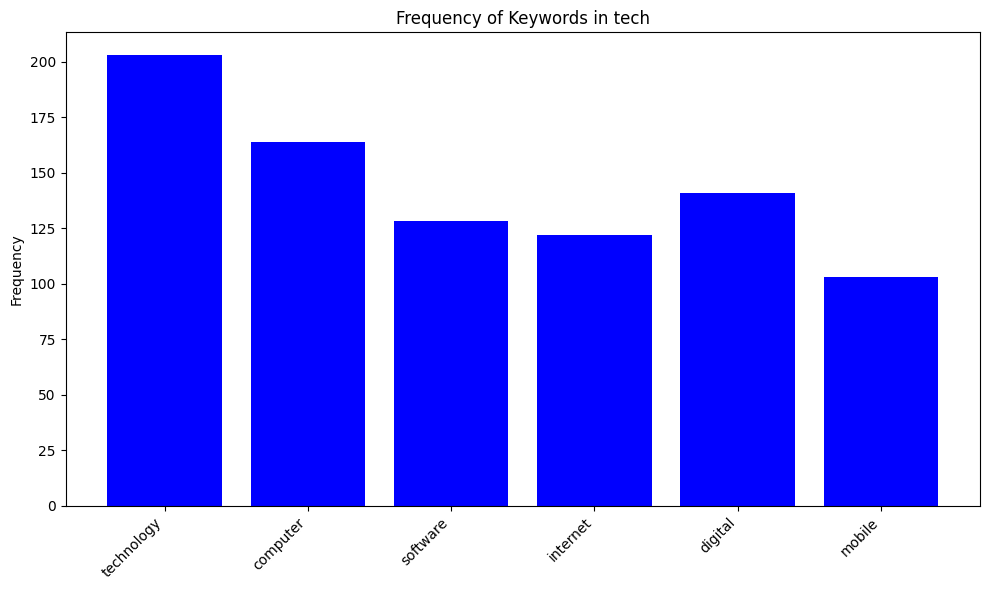

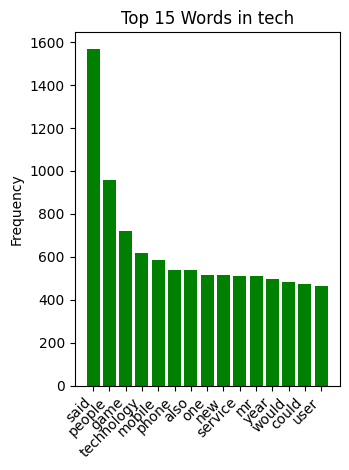

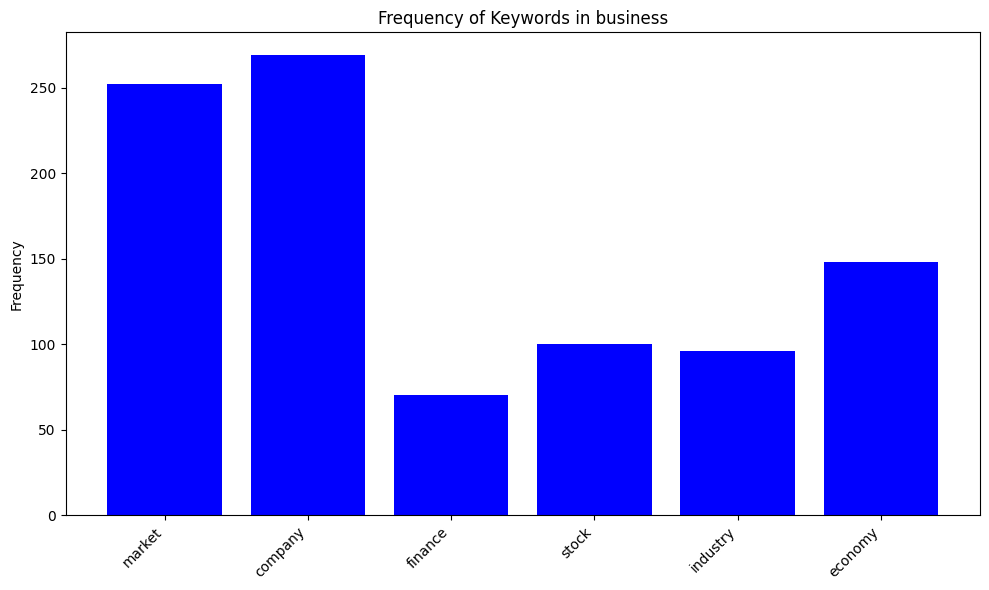

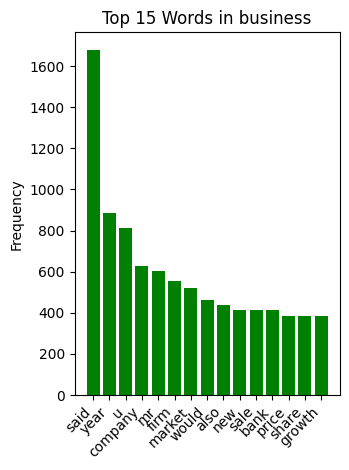

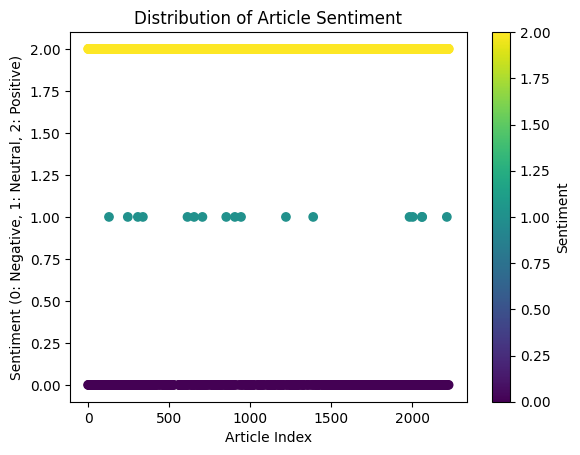

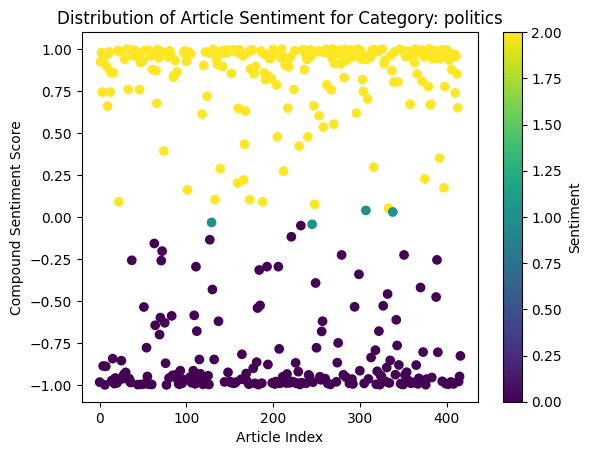

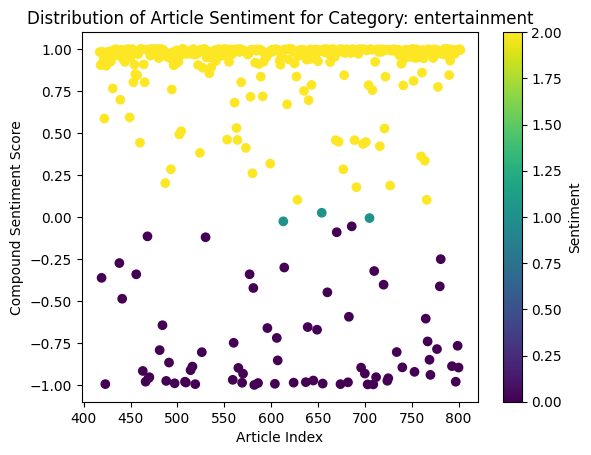

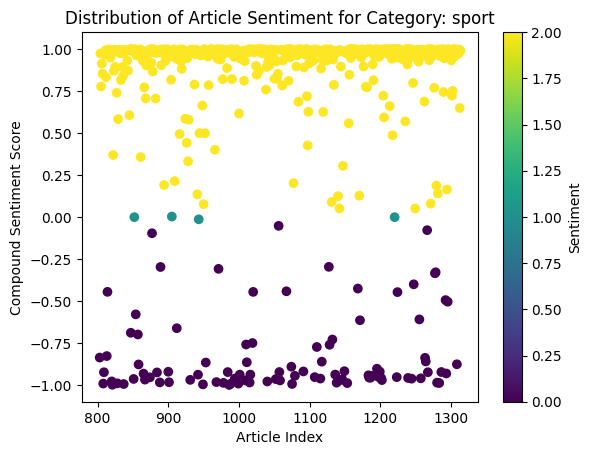

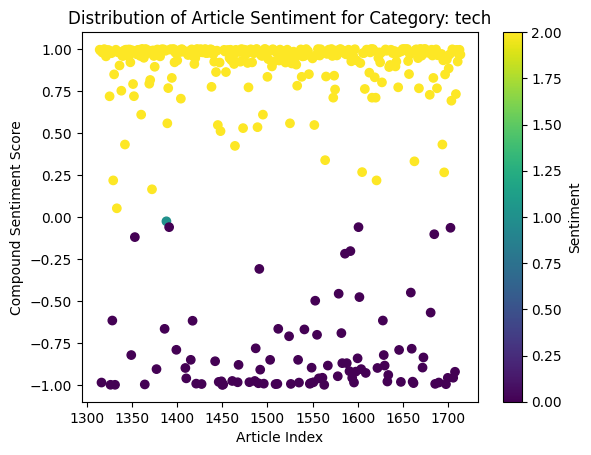

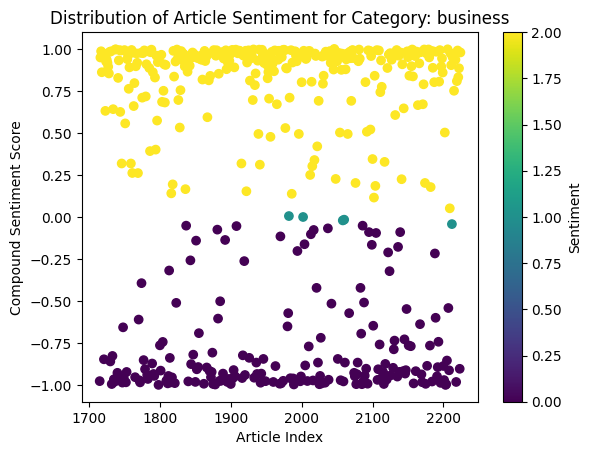

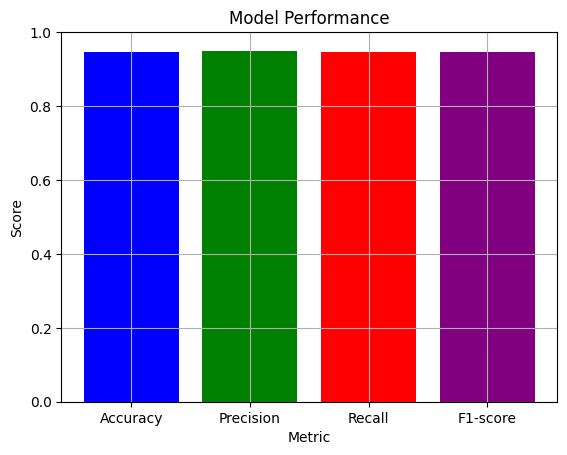

In [12]:
'''
The required code main run function
'''
def main():
    bbc_dir = "/content/bbc/"  # The directory of all the BBC's articles, assuming they are in /content/bbc/ (works on Google Collab)
    categories = ["politics", "entertainment", "sport", "tech", "business"]
    data = []

    for category in categories:
        category_path = os.path.join(bbc_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                filepath = os.path.join(category_path, filename)
                try:
                  with open(filepath, 'r', encoding='latin-1') as file: # Handle potential encoding issues
                      text = file.read()
                      preprocessed_text, num_of_word, words_frequency, average_sentient, compound_score, has_keywords = preprocess_text(text, category)
                      data.append([preprocessed_text, category, num_of_word, words_frequency, average_sentient, compound_score, has_keywords])
                except Exception as e:
                  print(f"Error processing file {filename}: {e}") # Catch and report errors during file processing
    df = output(data)
    # Mean number of text per article in each category
    categories_average_text_length = df.groupby('category')['number of text'].mean()
    # Dataset of emotion of entire dataset
    emotion_counts_per_category = df.groupby('category')['article emotion'].value_counts().unstack(fill_value=0)
    emotion_compound_score = df.groupby('category')['compound score']
    # Number of articles with words in their keywords, and the percentage
    categories_total_in_keywords = df.groupby('category')['has keyword'].sum()
    categories_total_in_keywords_percentage = categories_total_in_keywords / df.groupby('category').size()


    print("Your data:")
    print(f"Your dataset has: {categories_total_in_keywords} .")
    print(f"Which in percentage of all articles in the same category: {categories_total_in_keywords_percentage} .")
    print(f"On average, the number of words per article is: {categories_average_text_length}. ")
    print(df)
    print(emotion_counts_per_category)

    #part 2 training the data and evaulating
# Create a TF-IDF vectorizer for word frequencies:
    vectorizer = TfidfVectorizer()
    X_text = vectorizer.fit_transform(df['text'])  # Transform text data into TF-IDF features

    # Create numerical features for sentiment and keywords:
    # One-hot encode 'article emotion'
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for dense output
    emotion_encoded = encoder.fit_transform(df[['article emotion']])

    # Combine encoded emotion and 'has keyword'
    X_other = np.concatenate([emotion_encoded, df[['has keyword']].values], axis=1)

    # Combine text features (TF-IDF) and other features:
    X = sp.hstack([X_text, X_other])
    y = df['category']

    from sklearn.feature_selection import SelectKBest, chi2
    selector = SelectKBest(chi2, k=1000)  # Choose k based on experimentation
    X = selector.fit_transform(X, y)

    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Selecting features
    X_train_new, selected_feature_indices = select_features(X_train, y_train, k=1000)
    X_test_new = X_test[:, selected_feature_indices]

    # 2. Model Training
    from sklearn.naive_bayes import MultinomialNB  # Example model
    model = MultinomialNB()
    model.fit(X_train_new, y_train)

    # 3. Model Evaluation
    y_pred = model.predict(X_test_new)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))  # Print the classification report



    #Part 3: Graph the Part 1 results and Part 2 model evaulations
    categories_average_text_length = df.groupby('category')['number of text'].mean()

    # Create a histogram for number of texts per article
    plt.hist(df['number of text'], bins=np.arange(0, df['number of text'].max() + 50, 50))
    plt.xlabel('Number of Words in Article')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Words per Article')
    plt.show()

    # Create a bar graph for category average text length
    plt.bar(categories_average_text_length.index, categories_average_text_length.values)
    plt.xlabel('Category')
    plt.ylabel('Average Number of Words')
    plt.title('Average Number of Words per Category')
    plt.show()

    categories_total_in_keywords = df.groupby('category')['has keyword'].sum()
    categories_total_in_keywords_percentage = categories_total_in_keywords / df.groupby('category').size()

    # Create a bar graph for articles with keywords
    plt.bar(categories_total_in_keywords.index, categories_total_in_keywords.values)
    plt.xlabel('Category')
    plt.ylabel('Number of Articles with Keywords')
    plt.title('Articles with Keywords per Category')
    plt.show()

    # Create a bar graph for percentage of articles with keywords
    plt.bar(categories_total_in_keywords_percentage.index, (categories_total_in_keywords_percentage.values) * 100 )
    plt.xlabel('Category')
    plt.ylabel('Percentage of Articles with Keywords')
    plt.title('Percentage of Articles with Keywords per Category')
    plt.show()

    all_words = ' '.join(df['text']).split()
    word_counts = Counter(all_words)
    top_15_words = word_counts.most_common(15)

    # Create a bar graph for word frequency
    plt.bar([word[0] for word in top_15_words], [word[1] for word in top_15_words])
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 15 Most Frequent Words')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.show()

    categories = df['category'].unique() #iterate through the 5 categories in the df
    keywords = {
            "politics": ["politics", "election", "parliament", "government", "minister"],
            "entertainment": ["film", "movie", "actor", "celebrity", "music", "television"],
            "sport": ["football", "tennis", "cricket", "athlete", "game", "sports"],
            "tech": ["technology", "computer", "software", "internet", "mobile", "digital"],
            "business": ["economy", "market", "company", "finance", "stock", "industry"]
        }
    for category in categories:
      # Filter data for the current category
      category_df = df[df['category'] == category]
        # Count the frequency of each keyword in the category
      keyword_counts = Counter()
      for text in category_df['text']:
          for keyword in keywords[category]:
              if keyword in text:
                  keyword_counts[keyword] += 1

      # Create bar graph for keyword frequencies
      plt.figure(figsize=(10, 6))  # Adjust figure size as needed
      plt.bar(keyword_counts.keys(), keyword_counts.values(), color='blue')
      plt.title(f'Frequency of Keywords in {category}')
      plt.ylabel('Frequency')
      plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
      plt.tight_layout()  # Adjust layout for better spacing
      plt.show()

      # Get top 15 words in the category (this part remains the same)
      all_words = ' '.join(category_df['text']).split()
      word_counts = Counter(all_words)
      top_15_words = word_counts.most_common(15)

      # Create bar graph for top 15 words
      plt.subplot(1, 2, 2)  # Create subplot for top words
      plt.bar([word[0] for word in top_15_words], [word[1] for word in top_15_words], color='green')
      plt.title(f'Top 15 Words in {category}')
      plt.ylabel('Frequency')
      plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

      plt.tight_layout()  # Adjust layout for better spacing
      plt.show()

    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Map sentiment to numerical values
    df['sentiment_numeric'] = df['article emotion'].map(sentiment_mapping)

    plt.scatter(df.index, df['sentiment_numeric'], c=df['sentiment_numeric'], cmap='viridis')
    plt.xlabel('Article Index')
    plt.ylabel('Sentiment (0: Negative, 1: Neutral, 2: Positive)')
    plt.title('Distribution of Article Sentiment')
    plt.colorbar(label='Sentiment')  # Add a colorbar to show sentiment mapping
    plt.show()
    #same as the above scattergraph but with specific compound scores, into 5 graphs of each category

    for category in categories:
        category_df = df[df['category'] == category]
        plt.figure()  # Create a new figure for each category
        plt.scatter(category_df.index, category_df['compound score'], c=category_df['article emotion'].map(sentiment_mapping), cmap='viridis')
        plt.xlabel('Article Index')
        plt.ylabel('Compound Sentiment Score')
        plt.title(f'Distribution of Article Sentiment for Category: {category}')
        plt.colorbar(label='Sentiment')
        plt.show()

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    values = [accuracy, precision, recall, f1]

    plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])  # Customize colors
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Model Performance')
    plt.ylim(0, 1)  # Set y-axis limits to 0-1 for scores
    plt.grid(True)  # Add a grid for better readability
    plt.show()

if __name__ == "__main__":
    main()
